## check speed distributions for different trial types

In [42]:
%matplotlib inline
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp, mannwhitneyu, ks_2samp
import pandas as pd
from importlib import reload
from joblib import delayed, Parallel

import matplotlib.pyplot as plt
import seaborn as sns

import TreeMazeAnalyses2,Analyses.tree_maze_functions as tmf
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.plot_functions as pf
import TreeMazeAnalyses2.Utils.robust_stats as rs

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
ei = reload(ei)
info = ei.SummaryInfo()

### try for one session

In [3]:
subject_widget = widgets.Dropdown(options=info.subjects)
session_widget = widgets.Dropdown(options=info.sessions_by_subject[subject_widget.value])
task_widget = widgets.Dropdown(options=['T3', 'OF'])

def update_sessions(*args):
    all_sessions = info.sessions_by_subject[subject_widget.value]
    task_sessions = [session for session in all_sessions if task_widget.value in session]
    session_widget.options = task_sessions

def get_session(subject, task, session):
    return ei.SubjectSessionInfo(subject, session)

subject_widget.observe(update_sessions, names='value')
task_widget.observe(update_sessions, names='value')
o=widgets.interactive(get_session, subject=subject_widget, task=task_widget, session=session_widget)
display(o)

interactive(children=(Dropdown(description='subject', options=('Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi'), value='Li'…

In [305]:
session = session_widget.value
session_info = o.result
print(session_info)


Session Information for subject Li, session Li_T3g_061318
Number of curated units: 21
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> pos_zones. Executed = True
  -> event_table. Executed = True
  -> trial_zone_rates. Executed = False
  -> zone_rates_comps. Executed = True
  -> zone_rates_remap. Executed = True
  -> pop_zone_rates_remap. Executed = True
  -> bal_conds_seg_rates. Executed = True
  -> bal_conds_seg_boot_rates. Executed = nan
  -> zone_encoder. Executed = True
  -> zone_decoder. Executed = True

To run all analyses use run_analyses().



In [306]:
tmf = reload(tmf)
ta = tmf.TrialAnalyses(session_info)

In [333]:
min_sp = 30
max_sp = 1000
mean_trial_speeds = pd.DataFrame(np.zeros( (ta.n_trials, 2)) , columns=['out','in'])

for trial_seg in ['out','in']:
    _,_,sp=ta.get_trial_track_pos(trial_seg=trial_seg)
    mean_trial_speeds[trial_seg] = [np.nanmean(trial_sp[(trial_sp>=min_sp) & ((trial_sp<=max_sp))]) for trial_sp in sp]

trial_cond_types = ['Co', 'Inco']
trial_seg = 'in'

mean_trial_speeds['Rw'] = 'Co'
mean_trial_speeds.loc[ta.trial_table.correct==0, 'Rw'] = 'Inco'


/tmp/ipykernel_22069/3514088476.py:7: RuntimeWarning: Mean of empty slice
  mean_trial_speeds[trial_seg] = [np.nanmean(trial_sp[(trial_sp>=min_sp) & ((trial_sp<=max_sp))]) for trial_sp in sp]


MannwhitneyuResult(statistic=2.221e+03, pvalue=0.5939916207084066)
Ttest_indResult(statistic=0.5327253670019526, pvalue=0.5950505611736039)
KstestResult(statistic=0.14523809523809525, pvalue=0.5213526255466086)


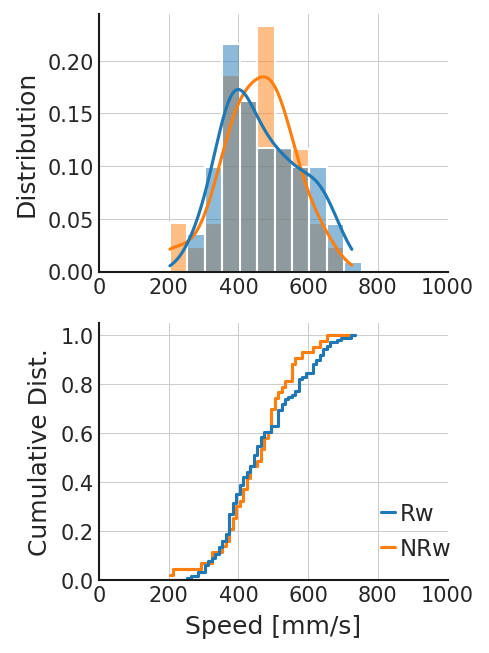

In [334]:
f,ax = plt.subplots(2,1, figsize=(3,5), dpi=150)
for a in ax:
    pf.setup_axes(a)

sns.histplot(x=trial_seg, hue='Rw', data=mean_trial_speeds, common_norm=False, stat='probability', palette='tab10', binwidth=50, multiple='layer', kde=True, ax=ax[0], legend=False, hue_order=['Co', 'Inco'])
ax[0].set_xlim(0,1000)
ax[0].set_xlabel("")
ax[0].set_ylabel("Distribution")

sns.histplot(x=trial_seg, hue='Rw', data=mean_trial_speeds, common_norm=False, stat="probability", palette='tab10', binwidth=10, multiple='layer', kde=False, cumulative=True, fill=False, element='step', ax=ax[1], legend=False, hue_order=['Co', 'Inco'])
ax[1].set_xlim(0,1000)
ax[1].set_xlabel("Speed [mm/s]")
ax[1].set_ylabel("Cumulative Dist.")
legend_elements = [plt.Line2D([0], [0], color=plt.cm.tab10(0),
                              label=f"Rw"),
                   plt.Line2D([0], [0], color=plt.cm.tab10(1),
                              label="NRw"),
                   ]
ax[1].legend(handles=legend_elements,loc='lower left', bbox_to_anchor=[0.75,0], handlelength=0.6, handletextpad=0.2, frameon=False)

x = median_trial_speeds.loc[mean_trial_speeds['Rw']=='Co', trial_seg]
y = median_trial_speeds.loc[mean_trial_speeds['Rw']=='Inco', trial_seg]
print(mannwhitneyu(x, y))
print(ttest_ind(x, y))
print(ks_2samp(x, y))

# plt.show()

In [335]:
co_samps = ta.get_trial_concat_samps(trials=mean_trial_speeds.index[(mean_trial_speeds['Rw']=='Co')],trial_seg='in')
inco_samps = ta.get_trial_concat_samps(trials=mean_trial_speeds.index[(mean_trial_speeds['Rw']=='Inco')], trial_seg='in')

co_sp =ta.track_data.loc[co_samps,'sp'].to_numpy()
co_sp[co_sp>1000]=np.nan
co_sp[co_sp<50]=np.nan
inco_sp =ta.track_data.loc[inco_samps,'sp'].to_numpy()
inco_sp[inco_sp>1000]=np.nan
inco_sp[inco_sp<50]=np.nan


MannwhitneyuResult(statistic=36625960.5, pvalue=7.471124275866173e-05)
Ttest_indResult(statistic=5.275040229385387, pvalue=1.342393637655582e-07)
KstestResult(statistic=0.07033821630657322, pvalue=4.5098951338166546e-17)


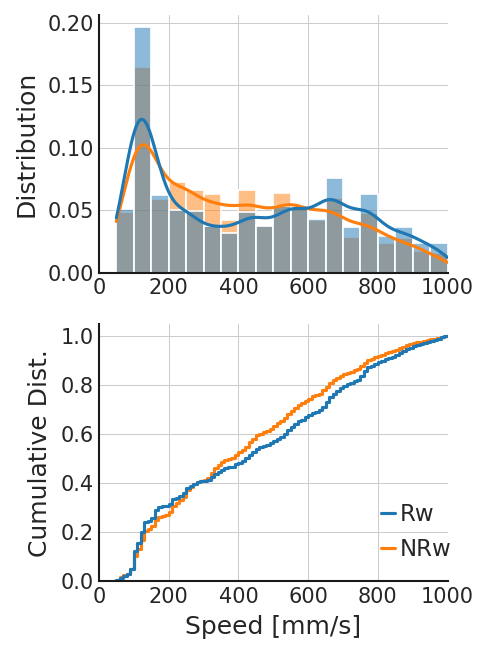

In [336]:
trial_speeds = pd.DataFrame(np.concatenate((co_sp, inco_sp)), columns=['sp'])
trial_speeds['Rw'] = ['Co']*len(co_sp)+['Inco']*len(inco_sp)

f,ax = plt.subplots(2,1, figsize=(3,5), dpi=150)
for a in ax:
    pf.setup_axes(a)

sns.histplot(x='sp', hue='Rw', data=trial_speeds, common_norm=False, stat='probability', palette='tab10', binwidth=50, multiple='layer', kde=True, ax=ax[0], legend=False, hue_order=['Co', 'Inco'])
ax[0].set_xlim(0,1000)
ax[0].set_xlabel("")
ax[0].set_ylabel("Distribution")

sns.histplot(x='sp', hue='Rw', data=trial_speeds, common_norm=False, stat="probability", palette='tab10', binwidth=10, multiple='layer', kde=False, cumulative=True, fill=False, element='step', ax=ax[1], legend=False, hue_order=['Co', 'Inco'])
ax[1].set_xlim(0,1000)
ax[1].set_xlabel("Speed [mm/s]")
ax[1].set_ylabel("Cumulative Dist.")
legend_elements = [plt.Line2D([0], [0], color=plt.cm.tab10(0),
                              label=f"Rw"),
                   plt.Line2D([0], [0], color=plt.cm.tab10(1),
                              label="NRw"),
                   ]
ax[1].legend(handles=legend_elements,loc='lower left', bbox_to_anchor=[0.75,0], handlelength=0.6, handletextpad=0.2, frameon=False)

x = trial_speeds.loc[trial_speeds['Rw']=='Co', 'sp'].dropna()
y = trial_speeds.loc[trial_speeds['Rw']=='Inco', 'sp'].dropna()
print(mannwhitneyu(x, y))
print(ttest_ind(x, y))
print(ks_2samp(x, y))

## matching trial speeds

In [340]:
co_trials = (mean_trial_speeds.Rw=='Co')
inco_trials = (mean_trial_speeds.Rw=='Inco')
in_sp = mean_trial_speeds['in']

co_trials[np.isnan(in_sp)] = False
inco_trials[np.isnan(in_sp)] = False

x = mean_trial_speeds.loc[co_trials, 'in'].to_numpy()
y = mean_trial_speeds.loc[inco_trials, 'in'].to_numpy()

mean_trial_speeds['valid_trials'] = co_trials | inco_trials
mean_trial_speeds['co_sort'] = np.nan
mean_trial_speeds.loc[co_trials, 'co_sort'] = np.argsort(x)

mean_trial_speeds['inco_sort'] = np.nan
mean_trial_speeds.loc[inco_trials, 'inco_sort'] = np.argsort(y)

mean_trial_speeds

,out,in,Rw,valid_trials,co_sort,inco_sort
0,246.605965,529.501259,Co,True,110.0,NaN
1,230.790359,523.162975,Inco,True,NaN,34.0
2,269.730025,398.713054,Co,True,95.0,NaN
3,315.825194,296.998106,Inco,True,NaN,39.0
4,327.034414,328.914672,Inco,True,NaN,1.0
...,...,...,...,...,...,...
150,264.003462,470.549132,Inco,True,NaN,13.0
151,225.905147,324.173352,Inco,True,NaN,28.0
152,209.539803,437.988272,Inco,True,NaN,11.0
153,258.718997,255.241470,Co,True,70.0,NaN


In [338]:
from statsmodels.nonparametric import kde

Text(0, 0.5, 'Distribution')

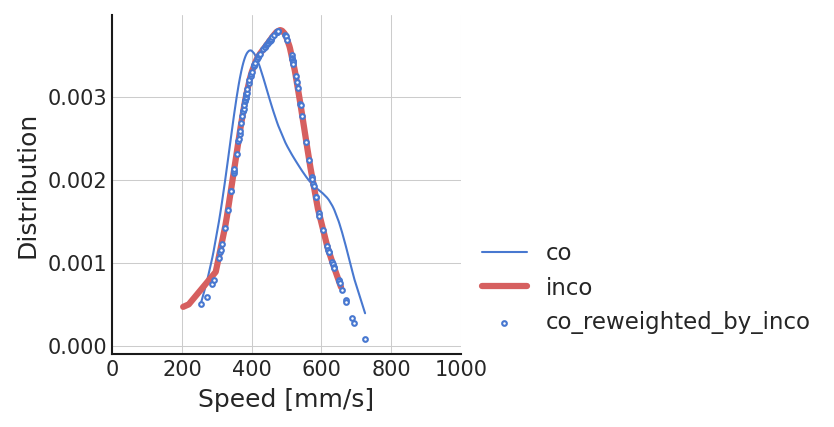

In [412]:
x.sort()
y.sort()
k_x = kde.KDEUnivariate(x).fit(bw='silverman', fft=True)
k_y = kde.KDEUnivariate(y).fit(bw='silverman', fft=True)


mean_trial_speeds['co_weighted'] = k_x.evaluate(mean_trial_speeds['in'].to_numpy())
mean_trial_speeds['inco_weighted'] = k_y.evaluate(mean_trial_speeds['in'].to_numpy())
              
mean_trial_speeds.loc[co_trials, 'co_weighted'] = 1
mean_trial_speeds.loc[inco_trials, 'inco_weighted'] = 1


f,ax = plt.subplots(figsize=(3,3), dpi=150)
pf.setup_axes(ax)

ax.plot(x,k_x.evaluate(x), label='co', lw=1)
ax.plot(y,k_y.evaluate(y), label='inco', lw=3, c='r')

ax.scatter(x,k_y.evaluate(x), label='co_reweighted_by_inco', s=5, fc='white', ec='b', zorder=10)
ax.legend(frameon=False, loc='lower left', bbox_to_anchor=[1,0])
ax.set_xlim(0,1000)
ax.set_xlabel("Speed [mm/s]")
ax.set_ylabel("Distribution")


In [356]:
mean_trial_speeds

,out,in,Rw,valid_trials,co_sort,inco_sort,co_weighted,inco_weighted
0,246.605965,529.501259,Co,True,110.0,NaN,0.002209,0.003183
1,230.790359,523.162975,Inco,True,NaN,34.0,0.002252,0.003332
2,269.730025,398.713054,Co,True,95.0,NaN,0.003563,0.003282
3,315.825194,296.998106,Inco,True,NaN,39.0,0.001276,0.000890
4,327.034414,328.914672,Inco,True,NaN,1.0,0.002147,0.001557
...,...,...,...,...,...,...,...,...
150,264.003462,470.549132,Inco,True,NaN,13.0,0.002723,0.003784
151,225.905147,324.173352,Inco,True,NaN,28.0,0.002002,0.001441
152,209.539803,437.988272,Inco,True,NaN,11.0,0.003168,0.003603
153,258.718997,255.241470,Co,True,70.0,NaN,0.000523,0.000506


In [354]:
#k_x.evaluate(mean_trial_speeds['in'])
k_x.evaluate(mean_trial_speeds['in'].to_numpy())

array([2.20871698e-03, 2.25170242e-03, 3.56285179e-03, 1.27566526e-03,
       2.14700239e-03, 2.69588341e-03, 1.94847793e-03, 2.30016525e-03,
       2.70390173e-03, 1.98332725e-03, 2.47625087e-03, 1.06148108e-03,
       1.75460995e-03, 3.52092464e-03, 3.47647567e-03, 2.22960847e-03,
       3.51651174e-03, 1.97187173e-03, 1.17908010e-03, 1.46914315e-03,
       3.17663412e-03, 2.51561444e-03, 2.53971657e-03, 3.15711497e-03,
       2.14043752e-03, 2.24749069e-03, 3.55970617e-03, 3.43663027e-03,
       2.43780640e-03, 3.08102223e-03, 1.63553055e-03, 1.41097391e-03,
       8.93994055e-04, 2.34560967e-03, 2.28519986e-03, 3.43404668e-03,
       2.67962671e-03, 1.95085192e-03, 1.78732962e-03, 2.93974806e-03,
       3.02796317e-03, 1.77616314e-03, 3.10433968e-03, 3.23288824e-03,
       3.45732143e-03, 1.21235593e-03, 3.49814682e-03, 1.36502467e-03,
       1.62666312e-03, 1.68878815e-03, 3.52059081e-03, 2.82185982e-03,
       2.45355058e-03, 1.64547726e-03, 3.16326851e-03, 2.69669212e-03,
      

In [347]:
mean_trial_speeds

,out,in,Rw,valid_trials,co_sort,inco_sort
0,246.605965,529.501259,Co,True,110.0,NaN
1,230.790359,523.162975,Inco,True,NaN,34.0
2,269.730025,398.713054,Co,True,95.0,NaN
3,315.825194,296.998106,Inco,True,NaN,39.0
4,327.034414,328.914672,Inco,True,NaN,1.0
...,...,...,...,...,...,...
150,264.003462,470.549132,Inco,True,NaN,13.0
151,225.905147,324.173352,Inco,True,NaN,28.0
152,209.539803,437.988272,Inco,True,NaN,11.0
153,258.718997,255.241470,Co,True,70.0,NaN


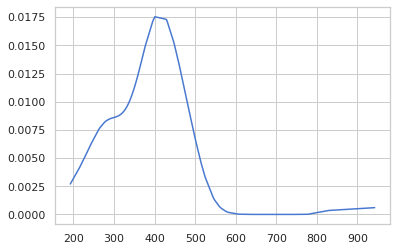

In [278]:
x_weighted_by_y = k.evaluate(x)
x_weighted_by_y /= x_weighted_by_y.sum()
plt.plot(x,x_weighted_by_y)

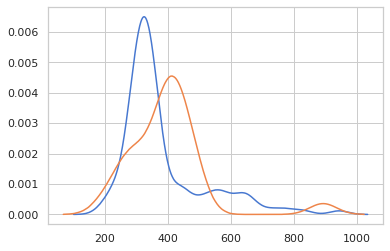

In [253]:
from KDEpy import FFTKDE

xx,x_h=FFTKDE(bw='silverman').fit(x)()
yy,y_h=FFTKDE(bw='silverman').fit(y)()

plt.plot(xx,x_h)
plt.plot(yy,y_h)

In [256]:
?FFTKDE.fit

Signature: FFTKDE.fit(self, data, weights=None)
Docstring:
Fit the KDE to the data. This validates the data and stores it.
Computations are performed upon evaluation on a specific grid.

Parameters
----------
data: array-like
    The data points.
weights: array-like
    One weight per data point. Must have same shape as the data.

Returns
-------
self
    Returns the instance.

Examples
--------
>>> data = [1, 3, 4, 7]
>>> weights = [3, 4, 2, 1]
>>> kde = FFTKDE().fit(data, weights=None)
>>> kde = FFTKDE().fit(data, weights=weights)
>>> x, y = kde.evaluate()
File:      ~/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/KDEpy/FFTKDE.py
Type:      function
